<p style="font-size:40px">Machine Learning Classification Part 1</p> <br>

<p style="font-family:'Courier New'">Pada jupyter notebook ini, diawali dengan <i>Hypothesis testing</i> seperti <i>Normality tests</i> dan <i>Significance tests.</i> Kemudian dilanjutkan dengan <i>preprocessing</i> pada dataset, seperti <i>feature selection</i> dan <i>feature scaling</i>. Dan juga, dari eksplorasi data sebelumnya sudah diperlihatkan bahwa dataset ini <i>highly-imbalanced</i>. Itu kenapa, saya juga akan menerapkan SMOTE dan <i>nearmiss algorithm</i> untuk melakukan <i>oversampling</i> dan <i>undersampling</i> ke dataset ini. Kemudian dilanjutkan dengan <i>modeling</i> menggunakan default model. 
    
> <p style="font-family:'Courier New'">Tujuan objektif dari Jupyter notebook ini adalah memberikan gambaran besar dalam dataset setelah di <i>resampling</i> atau sebelum di <i>resampling</i> menggunakan default model. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import shapiro
import scipy.stats as ss

from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score, accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from mlxtend.plotting import plot_learning_curves

from yellowbrick.model_selection import LearningCurve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
bank = pd.read_csv('bank_clean.csv')

In [3]:
bank.head()

,age,job,marital,education,default,month,campaign,pdays,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,may,1,Never contacted before,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [12]:
bank['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree', 'illiterate'],
      dtype=object)

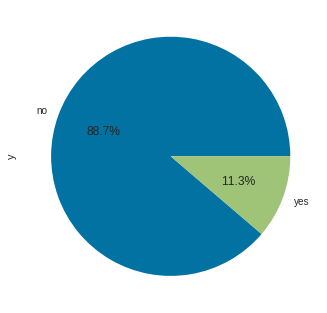

In [4]:
bank['y'].value_counts().plot(kind = 'pie',autopct='%1.1f%%')

> Terlihat bahwa dataset ini highly-unbalanced

# Hypothesis Testing

> <p style="font-family:'Courier New'">Melakukan tes hipotesis ke dataset berguna untuk memastikan bahwa semua fitur-fitur yang digunakan mempunyai pengaruh atau ada perbedaan yang signifikan secara statisik pada target. 

In [5]:
categorical = list(bank.select_dtypes('object').columns.drop('y'))
numerical = list(bank.drop(list(bank.select_dtypes('object').columns), axis = 1).columns)

## Normality Test

In [6]:
shap = []

for i in numerical:
    if shapiro(bank[i])[1] < 0.05:
        shap.append('Reject Null Hypothesis')
    else:
        shap.append('Fail To reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : shap}, index = numerical)

,Hypothesis
age,Reject Null Hypothesis
campaign,Reject Null Hypothesis
emp.var.rate,Reject Null Hypothesis
cons.price.idx,Reject Null Hypothesis
cons.conf.idx,Reject Null Hypothesis
euribor3m,Reject Null Hypothesis
nr.employed,Reject Null Hypothesis


## Significance Test

In [7]:
mannwhit = []

for i in numerical:
    if mannwhitneyu(bank[bank['y'] == 'no'][i],bank[bank['y'] == 'yes'][i])[1] < 0.05:
        mannwhit.append('Reject Null Hypothesis')
    else:
        mannwhit.append('Fail To reject Null Hypothesis')

pd.DataFrame({'Hypothesis' : mannwhit}, index = numerical)

,Hypothesis
age,Reject Null Hypothesis
campaign,Reject Null Hypothesis
emp.var.rate,Reject Null Hypothesis
cons.price.idx,Reject Null Hypothesis
cons.conf.idx,Reject Null Hypothesis
euribor3m,Reject Null Hypothesis
nr.employed,Reject Null Hypothesis


In [8]:
chi2 = []

for i in categorical:
    if chi2_contingency(pd.crosstab(bank['y'], bank[i]))[1] < 0.05:
        chi2.append('Reject Null Hypothesis')
    else:
        chi2.append('Fail To Reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : chi2}, index = categorical)

,Hypothesis
job,Reject Null Hypothesis
marital,Reject Null Hypothesis
education,Reject Null Hypothesis
default,Reject Null Hypothesis
month,Reject Null Hypothesis
pdays,Reject Null Hypothesis
poutcome,Reject Null Hypothesis


> <p style="font-family:'Courier New'">Terlihat dari signifikansi tes di atas, bahwa fitur-fitur yang di dataset setelah dibersihkan adalah fitur-fitur yang signifikan. 

# Preprocessing

## Feature Selection


<p style="font-family:'Courier New'">Pada feature selection saya menggunakan analisa korelasi, yang dimana jika korelasi fitur terhadap target tidak ada (dalam asumsi saya, korelasi < 0.2 artinya fitur tersebut tidak punya korelasi). Maka akan saya buang fiturnya. 

In [9]:
#Correlation measurement untuk data discrete dan continous
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

#Correlation measurement untuk data discrete dan discrete
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

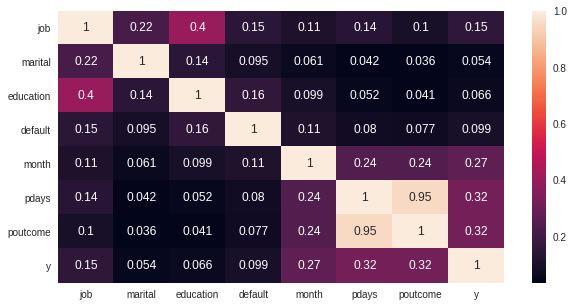

In [10]:
category = bank.select_dtypes(exclude = np.number)

corrCat = []
for i in category.columns:
    mat = []
    for j in category.columns:
        mat.append(cramers_v(bank[i],bank[j]))
    corrCat.append(mat)
    
dfcramers = pd.DataFrame(corrCat, index = category.columns, columns = category.columns)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)

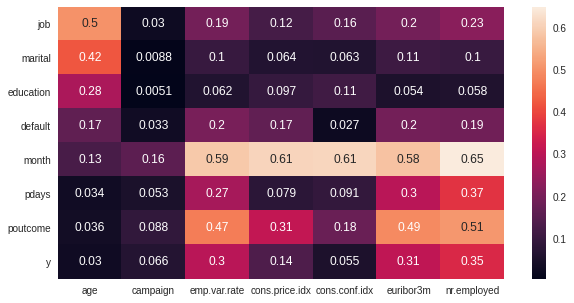

In [11]:
numeric = bank.drop(category.columns, axis = 1)

corrNumCat = []

for i in category.columns:
    mat2 = []
    for j in numeric.columns:
        mat2.append(correlation_ratio(bank[i],bank[j]))
    corrNumCat.append(mat2)

dfcramers = pd.DataFrame(corrNumCat, index = category.columns, columns = numeric.columns)
plt.figure(figsize = (10,5))
sns.heatmap(dfcramers,annot = True)

> <p style="font-family:'Courier New'">Pada analisa korelasi di atas dapat dilihat bahwa fitur <i>job, marital, education, default, age, campaign, cons.price.idx</i> dan <i>cons.conf.idx</i> tidak memiliki korelasi pada target. Namun karena saya bukan ahli di bidang ekonomi, saya memutuskan untuk tidak membuang socio-economics atribute. Kemudian juga, mengingat bahwa fitur yang tersisa tidak ada fitur pada profil nasabah, dan saya ingin model saya juga mempertimbangkan profil nasabah, saya memasukkan fitur age ke dalam model.

## Dataset Splitting

In [12]:
X = bank.drop('y', axis = 1)
y = bank['y'].map({'no' : 0, 'yes' : 1})

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 101)

## Build a pipeline

<p style="font-family:'Courier New'">Untuk mengurangi kemungkinan terjadinya <i>data leakage</i>, saya menggunakan bantuan <i>pipeline</i>. <i>Pipeline</i> yang saya gunakan berasal dari <i>package</i> imblearn mengingat akan dilakukannya <i>Synthetic Minority Over-sampling TEchnique (SMOTE)</i> dan <i>Near-miss algorithm</i>.

<p style="font-family:'Courier New'">Mengingat masih ada data-data outlier di dataset ini, saya menggunakan RobustScaler sebagai Feature Scaling ke data numerik. Kemudian dilanjutkan dengan melakukan <i>encoding</i> menggunakan OneHotEncoder ke data kategorik.

In [78]:
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['emp.var.rate','euribor3m','nr.employed','cons.price.idx','cons.conf.idx','age']),
        ('cat', categorical_transformer, ['month','pdays'])])

# Evaluation Metrics

<p style="font-family:'Courier New'">Dari analisa sebelumnya, telah disinggung bahwa dataset ini termasuk dataset yang highly-unbalanced. Itu kenapa pemilihan evaluasi metrik harus lebih berhati-hati. Pada kasus dataset yang highly-unbalanced, evaluasi metrik akurasi jadi tidak lagi relevan. Namun masalah lainnya, bagaimana menentukan metrik yang dapat 'fair' membandingkan model yang di fit dengan dataset sebelum resampling dan setelah resampling. 

<p style="font-family:'Courier New'">Pilihan metrik yang saya gunakan adalah $F1-Score$ (macro), $precision$ (macro), $recall$ (macro), dan Matthews Correlation Coefficient ($MCC$). Macro di sini adalah macro-average. Dimana saya pikir, macro-average akan sangat membantu saya dalam membandingkan model yang di fit dengan dataset sebelum resampling dan setelah resampling. Mengingat macro-average melihat dua kelas secara sama rata. Secara matematis:

<b><p style="font-family:'Courier New'">1. F1 score</b> adalah <i>harmonic mean</i> dari precision dan recall yang dapat ditulis sebagai berikut:
$$F1 = 2\frac{precision\cdot recall}{precision+recall}$$
dimana:
$$ precision(posLabel = 1) = precision(+) = \frac{TP}{TP+FP} = \frac{TruePositive}{ActualResult_{+}} $$
$$ recall(posLabel=1) = recall (+) = \frac{TP}{TP+FN} = \frac{TruePositive}{PredictedResult_{+}}$$


<b><p style="font-family:'Courier New'">2. Matthews Correlation Coefficient ($MCC$)</b> secara matematis dapat dituliskan sebagai berikut:

$$ MCC = \frac{TN\times TP-FP\times FN}{\sqrt{(TN+FN)(FP+TP)(TN+FP)(FN+TP)}} $$

$MCC$ menjadi salah satu evaluasi metrik yang sering diperlihatkan pada kasus imbalance class, karena dia bersifat <b><i>perfectly symmetric</i></b>. Yang artinya setiap kelas dinilai sama pentingnya. 

<b><p style="font-family:'Courier New'">3. Macro Average </b> menghitung rata-rata suatu nilai tiap kelas. Misalnya untuk f-score untuk masalah klasifikasi biner:

$$ macroF1 = \frac{F1_{1}+F1_{2}}{2} $$

> <p style="font-family:'Courier New'">Catatan: Dalam kasus pemilihan modelling terbaik, saya hanya melihat macro f1-score tertinggi. 


In [15]:
def evaluationMetrics(y_test, y_pred):
    f1.append(f1_score(y_test,y_pred, average = 'macro'))
    prec.append(precision_score(y_test, y_pred, average = 'macro'))
    recall.append(recall_score(y_test, y_pred, average = 'macro'))
    matthews.append(matthews_corrcoef(y_test, y_pred))

# Modeling

<p style="font-family:'Courier New'">Model yang saya gunakan adalah: Logistic Regression, Random Forest Classifier, dan XGBoost Classifier. 

## ModelDefault-Without resampling

In [16]:
metricDefault_Original = pd.DataFrame(index = ['Logistic Regression',
                                             'Random Forest Classifier',
                                             'XGBoost Classifier']) 
f1 = []
prec = []
recall = []
matthews = []

### Make pipeline for all models

> <p style="font-family:'Courier New'">Sebetulnya, model random forest dan xgboost tidak membutuhkan scaling. Namun agar memastikan model berada di satu halaman yang sama, maka saya rasa tidak masalah jika scaling juga dilakukan ke random forest dan xgboost juga. 

In [17]:
logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('logreg', LogisticRegression(random_state = 101))])

rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rfc', RandomForestClassifier(random_state = 101))])

xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgb', XGBClassifier(random_state = 101))])

### Logistic Regression

In [18]:
logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [19]:
y_pred_log = logreg.predict(X_test)

evaluationMetrics(y_test, y_pred_log)

In [20]:
confusion_matrix(y_test, y_pred_log)

array([[7173,  106],
       [ 739,  220]])

In [21]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.91      0.99      0.94      7279
           1       0.67      0.23      0.34       959

    accuracy                           0.90      8238
   macro avg       0.79      0.61      0.64      8238
weighted avg       0.88      0.90      0.87      8238



### Random Forest Classifier

In [22]:
rfc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [23]:
y_pred_rfc = rfc.predict(X_test)

evaluationMetrics(y_test, y_pred_rfc)

In [24]:
confusion_matrix(y_test, y_pred_rfc)

array([[7002,  277],
       [ 681,  278]])

In [25]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      7279
           1       0.50      0.29      0.37       959

    accuracy                           0.88      8238
   macro avg       0.71      0.63      0.65      8238
weighted avg       0.86      0.88      0.87      8238



### XGBoost Classifier

In [26]:
xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [27]:
y_pred_xgb = xgb.predict(X_test)

evaluationMetrics(y_test, y_pred_xgb)

In [28]:
confusion_matrix(y_test, y_pred_xgb)

array([[7107,  172],
       [ 702,  257]])

In [29]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7279
           1       0.60      0.27      0.37       959

    accuracy                           0.89      8238
   macro avg       0.75      0.62      0.66      8238
weighted avg       0.87      0.89      0.88      8238



## Evaluation

In [30]:
metricDefault_Original['Macro F1-Score'] = f1
metricDefault_Original['Macro Recall'] = recall
metricDefault_Original['Macro Precision'] = prec
metricDefault_Original['MCC'] = matthews

### Evaluation Metrics

In [31]:
metricDefault_Original

,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression,0.643394,0.607422,0.790722,0.353439
Random Forest Classifier,0.651605,0.625915,0.706132,0.322212
XGBoost Classifier,0.656195,0.622179,0.754586,0.352732


> <p style="font-family:'Courier New'">Dapat dilihat bahwa XGBoost (default) menjadi model terbaik untuk dataset orginal. 

### Learning Curves

#### Logistic Regresion

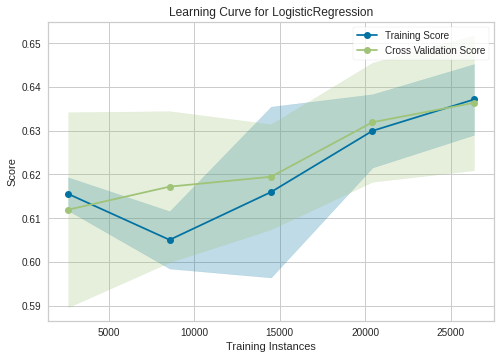

In [32]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    logreg, scoring = 'f1_macro', train_size = sizes, random_state = 101, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

><p style="font-family:'Courier New'">Pada logistic regression score berubah-berubah, adanya penurunan saat di training instances di bawah 10000, kemudian dia naik lagi dan terus menaik. Pada akhirnya titik training score lebih tinggi dari validation score. 

#### Random Forest Classifier

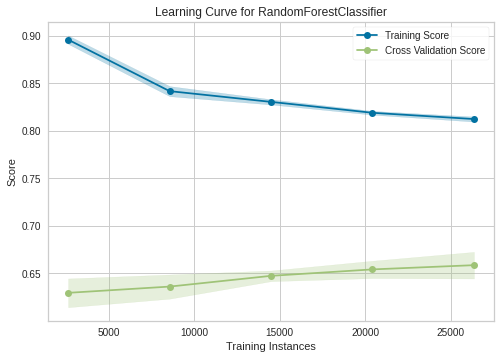

In [33]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc, scoring = 'f1_macro', train_size = sizes, random_state = 101, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> <p style="font-family:'Courier New'">Model di atas menunjukkan model mengalami <i>overfitting.</i> Namun itu bukanlah sesuatu yang mengejutkan mengingat Random Forest default memiliki max_depth = None.

#### XGBoost Classifier

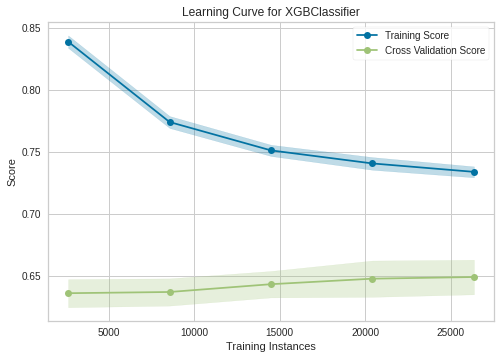

In [34]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    xgb, scoring = 'f1_macro', train_size = sizes, random_state = 101, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> <p style="font-family:'Courier New'">XGBoost juga sama dengan Random Forest, dia juga mengalami overfitting. Namun memang tidak separah Random Forest. 

# ModelDefault-With Smote

In [35]:
metricDefault_smote = pd.DataFrame(index = ['Logistic Regression (with SMOTE)', 
                                             'Random Forest Classifier (with SMOTE)', 
                                             'XGBoost Classifier (with SMOTE)']) 
f1 = []
prec = []
recall = []
matthews = []

## Smote

In [36]:
sm = SMOTE(random_state=101, sampling_strategy=1.0)

In [37]:
logreg_smote = Pipeline(steps=[('preprocessor', preprocessor), ('smote', sm),
                      ('logreg', LogisticRegression(random_state = 101))])

rfc_smote = Pipeline(steps=[('preprocessor', preprocessor), ('smote', sm),
                      ('rfc', RandomForestClassifier(random_state = 101))])

xgb_smote = Pipeline(steps=[('preprocessor', preprocessor), ('smote', sm),
                      ('xgb', XGBClassifier(random_state = 101))])

## Logistic Regression

In [38]:
logreg_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [39]:
y_pred_log_smote = logreg_smote.predict(X_test)

evaluationMetrics(y_test, y_pred_log_smote)

In [40]:
confusion_matrix(y_test, y_pred_log_smote)

array([[6295,  984],
       [ 372,  587]])

In [41]:
print(classification_report(y_test, y_pred_log_smote))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      7279
           1       0.37      0.61      0.46       959

    accuracy                           0.84      8238
   macro avg       0.66      0.74      0.68      8238
weighted avg       0.88      0.84      0.85      8238



## Random Forest Classifier

In [42]:
rfc_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [43]:
y_pred_rfc_smote = rfc_smote.predict(X_test)

evaluationMetrics(y_test, y_pred_rfc_smote)

In [44]:
confusion_matrix(y_test, y_pred_rfc_smote)

array([[6653,  626],
       [ 576,  383]])

In [45]:
print(classification_report(y_test, y_pred_rfc_smote))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      7279
           1       0.38      0.40      0.39       959

    accuracy                           0.85      8238
   macro avg       0.65      0.66      0.65      8238
weighted avg       0.86      0.85      0.86      8238



## XGBoost Classifier

In [46]:
xgb_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [47]:
y_pred_xgb_smote = xgb_smote.predict(X_test)

evaluationMetrics(y_test, y_pred_xgb_smote)

In [48]:
confusion_matrix(y_test, y_pred_xgb_smote)

array([[6652,  627],
       [ 471,  488]])

In [49]:
print(classification_report(y_test, y_pred_xgb_smote))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7279
           1       0.44      0.51      0.47       959

    accuracy                           0.87      8238
   macro avg       0.69      0.71      0.70      8238
weighted avg       0.88      0.87      0.87      8238



## Evaluation

### Evaluation Metrics

In [50]:
metricDefault_smote['Macro F1-Score'] = f1
metricDefault_smote['Macro Recall'] = recall
metricDefault_smote['Macro Precision'] = prec
metricDefault_smote['MCC'] = matthews

In [51]:
metricDefault_smote

,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression (with SMOTE),0.683400,0.738456,0.658925,0.389341
Random Forest Classifier (with SMOTE),0.653188,0.656687,0.649952,0.306565
XGBoost Classifier (with SMOTE),0.697174,0.711363,0.685772,0.396309


><p style="font-family:'Courier New'">Pada dataset oversampling XGBoost Classifier masih menjadi model terbaik. 

### Learning Curves

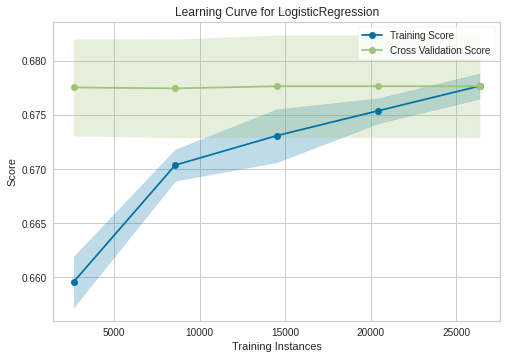

In [52]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    logreg_smote, scoring = 'f1_macro', train_size = sizes, random_state = 101, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> <p style="font-family:'Courier New'">Sebetulnya, ini pertama kalinya saya melihat score dari dataset test terus lebih baik dari dataset trainingnya. Namun ternyata menurut artikel [1], ada beberapa alasan hal ini dapat terjadi, dan salah satu alasan yang cukup relevan, bahwa dataset tes kita jauh lebih mudah diprediksi daripada data trainingnya. Namun saya masih tidak dapat melihat bagaimana saya menyelesaikan masalah ini. 

[1] https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/

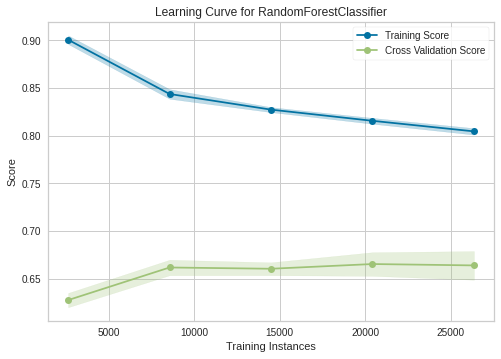

In [53]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_smote, scoring = 'f1_macro', train_size = sizes, random_state = 101, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> <p style="font-family:'Courier New'">Model masih mengalami overfitting, namun lebih baik dari sebelum-sebelumnya. Mengingat salah satu solusi pada overfitting adalah menambahkan data training, itu kenapa SMOTE agak mengurangi overfitting pada model. 

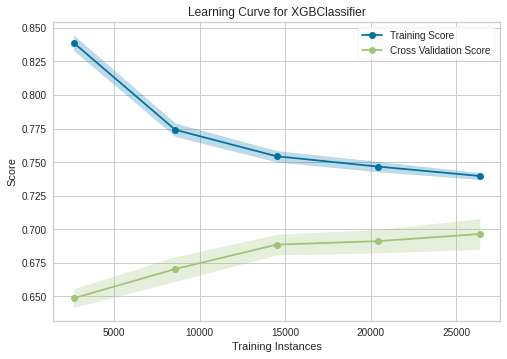

In [54]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    xgb_smote, scoring = 'f1_macro', train_size = sizes, random_state = 101, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> <p style="font-family:'Courier New'">Begitu juga dengan XGBoost, dia juga masih mengalami overfitting namun jauh lebih baik daripada tadi. Menambahkan training dataset akan membantu dalam kasus ini.

# ModelDefault-Nearmiss

In [55]:
metricDefault_nearmiss = pd.DataFrame(index = ['Logistic Regression (with Nearmiss)',
                                             'Random Forest Classifier (with Nearmiss)',
                                             'XGBoost Classifier (with NearMiss)']) 
f1 = []
prec = []
recall = []
matthews = []
auc = []

In [56]:
nr = NearMiss()

In [57]:
logreg_nearmiss = Pipeline(steps=[('preprocessor', preprocessor), ('nearmiss', nr),
                      ('logreg', LogisticRegression(random_state = 101))])

rfc_nearmiss = Pipeline(steps=[('preprocessor', preprocessor), ('nearmiss', nr),
                      ('rfc', RandomForestClassifier(random_state = 101))])

xgb_nearmiss = Pipeline(steps=[('preprocessor', preprocessor), ('nearmiss', nr),
                      ('xgb', XGBClassifier(random_state = 101))])

## Logistic Regression

In [58]:
logreg_nearmiss.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [59]:
y_pred_logreg_nearmiss = logreg_nearmiss.predict(X_test)

evaluationMetrics(y_test, y_pred_logreg_nearmiss)

In [60]:
confusion_matrix(y_test, y_pred_logreg_nearmiss)

array([[5715, 1564],
       [ 372,  587]])

In [61]:
print(classification_report(y_test, y_pred_logreg_nearmiss))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7279
           1       0.27      0.61      0.38       959

    accuracy                           0.76      8238
   macro avg       0.61      0.70      0.62      8238
weighted avg       0.86      0.76      0.80      8238



## Random Forest Classifier

In [62]:
rfc_nearmiss.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [63]:
y_pred_rfc_nearmiss = rfc_nearmiss.predict(X_test)

evaluationMetrics(y_test, y_pred_rfc_nearmiss)

In [64]:
confusion_matrix(y_test, y_pred_rfc_nearmiss)

array([[1323, 5956],
       [ 104,  855]])

In [65]:
print(classification_report(y_test, y_pred_rfc_nearmiss))

              precision    recall  f1-score   support

           0       0.93      0.18      0.30      7279
           1       0.13      0.89      0.22       959

    accuracy                           0.26      8238
   macro avg       0.53      0.54      0.26      8238
weighted avg       0.83      0.26      0.29      8238



## XGBoost Classifier

In [66]:
xgb_nearmiss.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                        

In [67]:
y_pred_xgb_nearmiss = xgb_nearmiss.predict(X_test)

evaluationMetrics(y_test, y_pred_xgb_nearmiss)

In [68]:
confusion_matrix(y_test, y_pred_xgb_nearmiss)

array([[2068, 5211],
       [ 128,  831]])

In [69]:
print(classification_report(y_test, y_pred_xgb_nearmiss))

              precision    recall  f1-score   support

           0       0.94      0.28      0.44      7279
           1       0.14      0.87      0.24       959

    accuracy                           0.35      8238
   macro avg       0.54      0.58      0.34      8238
weighted avg       0.85      0.35      0.41      8238



## Evaluation

### Evaluation Metrics

In [70]:
metricDefault_nearmiss['Macro F1-Score'] = f1
metricDefault_nearmiss['Macro Recall'] = recall
metricDefault_nearmiss['Macro Precision'] = prec
metricDefault_nearmiss['MCC'] = matthews

In [71]:
metricDefault_nearmiss

,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression (with Nearmiss),0.616323,0.698616,0.605891,0.290046
Random Forest Classifier (with Nearmiss),0.262003,0.536655,0.526326,0.062128
XGBoost Classifier (with NearMiss),0.336956,0.575316,0.539625,0.109259


<p style="font-family:'Courier New'">Logistic Regression menjadi model terbaik saat menggunakan nearmiss. 

### Learning Curves

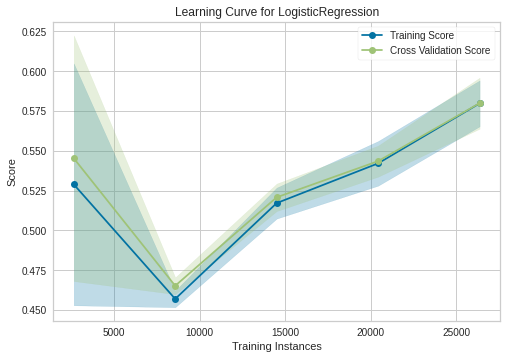

In [72]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    logreg_nearmiss, scoring = 'f1_macro', train_size = sizes, random_state = 101,  cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

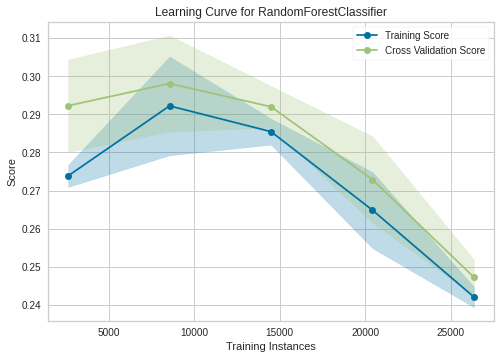

In [73]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    rfc_nearmiss, scoring = 'f1_macro', train_size = sizes, random_state = 101, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

><p style="font-family:'Courier New'">Random Forest mengalami underfitting, score condong ingin turun ke bawah.

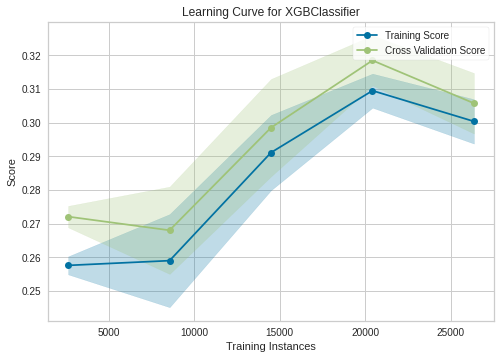

In [74]:
sizes = np.linspace(0.3, 1, 10)

visualizer = LearningCurve(
    xgb_nearmiss, scoring = 'f1_macro', train_size = sizes, random_state = 101, cv = 5
)

visualizer.fit(X_train, y_train)
visualizer.show()

> <p style="font-family:'Courier New'">XGBoost juga mengalami underfitting, mengingat score-score sebelumnya berada di kisaran 0.6an.

# Conclusion

In [75]:
print('NearMiss')
metricDefault_nearmiss

NearMiss


,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression (with Nearmiss),0.616323,0.698616,0.605891,0.290046
Random Forest Classifier (with Nearmiss),0.262003,0.536655,0.526326,0.062128
XGBoost Classifier (with NearMiss),0.336956,0.575316,0.539625,0.109259


In [76]:
print('SMOTE')
metricDefault_smote

SMOTE


,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression (with SMOTE),0.683400,0.738456,0.658925,0.389341
Random Forest Classifier (with SMOTE),0.653188,0.656687,0.649952,0.306565
XGBoost Classifier (with SMOTE),0.697174,0.711363,0.685772,0.396309


In [77]:
print('Original')
metricDefault_Original

Original


,Macro F1-Score,Macro Recall,Macro Precision,MCC
Logistic Regression,0.643394,0.607422,0.790722,0.353439
Random Forest Classifier,0.651605,0.625915,0.706132,0.322212
XGBoost Classifier,0.656195,0.622179,0.754586,0.352732


> <p style="font-family:'Courier New'">Secara keseluruhan, boleh dibilang bahwa dataset undersampling, kebanyakan model mengalami underfitting. Namun tidak dengan SMOTE dan original dataset. Itu kenapa, untuk analisa selanjutnya saya tidak akan menggunakan undersampling. Melainkan hanya original dataset dan SMOTE saja. 

> <p style="font-family:'Courier New'">Untuk evaluasi model, secara keseluruhan paling tinggi di model XGBoost dengan SMOTE. Tapi masalahnya, model kita hampir semuanya mengalami overfitting. Yang dimana artinya, model tidak stabil dan tidak general. Itu kenapa menyelesaikan overfitting akan menjadi fokus di notebook berikutnya, dimana saya akan melakukan tuning pada setiap model.  